# Introduction

We will use the python bindings for the [FANN](http://leenissen.dk/fann/wp/) (Fast Artificial Neural Networks) C-library to construct a neural network to map from the potential (represented by Fourier components, see [potentials.ipynb](potentials.ipynb)) to the eigenvalues (really, the difference between the eigenvalues and the square-well eigenvalues normalized by $\sqrt{\langle V_0^2 \rangle}$, see [eigenvalues.ipynb](eigenvalues.ipynb)). For FANN documentation, see [http://libfann.github.io/fann/docs/files/fann-h.html](http://libfann.github.io/fann/docs/files/fann-h.html).

# Preliminaries

In [45]:
%matplotlib inline
import numpy as np
from numpy.random import normal, randint
import matplotlib.pyplot as plt
from fann2 import libfann
from sklearn.cross_validation import train_test_split

# Number of basis states for the wavefunctions
NBW = 50
nbws = np.arange(1, NBW+1)
# Number of potentials:
NV = int(1E4)
# Number of basis states in the potential:
NB = 10
ns = np.arange(1, NB+1)
# lambda (variance of Legendre coefficients):
lam = 0.75
# The variance of the n=0 legendre coefficient V_0:
V20 = 10

# Input file:
filepath = "../Data/eigenvalues_NV" + str(NV) \
    + "_NB" + str(NB) + "_lam" \
    + str(lam) + "_V20" + str(V20) + ".npy"
filepathSD = "../Data/eigenvaluesSD_NV" + str(NV) \
    + "_NB" + str(NB) + "_lam" \
    + str(lam) + "_V20" + str(V20) + ".npy"
data = np.load(filepath)
dataSD = np.load(filepathSD)
VSns = data[::,0:10]
VCns = data[::,10:20]
eigs = data[::,20::]

In [46]:
print(data.shape, VSns.shape, VCns.shape, eigs.shape)
print(dataSD.shape)

(10000, 60) (10000, 10) (10000, 10) (10000, 40)
(40,)


# Preprocessing
We know that the spectrum is symmetric under $x\to -x$. We can build this into our dataset. We can duplicate the entire dataset but set all the Sine coefficients to their negative value. This effectively reflects the potential around the $y$-axis.

In [47]:
def VS(ns, xs):
    return np.sin(np.pi*np.outer(ns,xs))
def VC(ns, xs):
    return np.cos(np.pi*np.outer(ns,xs))
Nx = 100
xs = np.linspace(-1,1,Nx)
#Vgrid = legval(xs, np.transpose(Vns))
VSs = VS(ns,xs)
VCs = VC(ns,xs)

Vgrid = np.dot(VSns,VSs) + np.dot(VCns,VCs)
VgridFlipped = Vgrid[::,::-1]
print(Vgrid.shape)

(10000, 100)


In [48]:
numeigs = 10
X = np.concatenate( (np.concatenate((VSns, VCns), axis = 1), np.concatenate((-VSns, VCns), axis =1)) )
Xgrid = np.concatenate( (Vgrid, Vgrid[::,::-1]) )
y = np.concatenate( (eigs, eigs) )[::,1:numeigs+1]

In [49]:
# Split test and train
test_frac = 0.4
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_frac, random_state=7
)
test_frac = 0.4
X_train_grid, X_test_grid, y_train, y_test = train_test_split(
    Xgrid, y, test_size=test_frac, random_state=7
)

In [50]:
print(X.shape, y.shape)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

print(Xgrid.shape, y.shape)
print(X_train_grid.shape, y_train.shape)
print(X_test_grid.shape, y_test.shape)

(20000, 20) (20000, 10)
(12000, 20) (12000, 10)
(8000, 20) (8000, 10)
(20000, 100) (20000, 10)
(12000, 100) (12000, 10)
(8000, 100) (8000, 10)


# Neural network

In [51]:
# Model parameters
connection_rate = 1
learning_rate = 1
desired_error = 0.008
max_iterations = 5000
iterations_between_reports = 20
num_train = X_train.shape[0]
num_input = X_train[1].size
num_output = numeigs
network = (num_input, 30, num_output)

# Initialize the neural network
ann = libfann.neural_net()
ann.create_sparse_array(connection_rate, network)
ann.set_learning_rate(learning_rate)
ann.set_activation_function_output(libfann.SIGMOID_SYMMETRIC_STEPWISE)

# Specify the training data
fann_train = libfann.training_data()
fann_train.set_train_data(X_train.tolist(), y_train.tolist())

# Specify the test data
fann_test = libfann.training_data()
fann_test.set_train_data(X_test.tolist(), y_test.tolist())

In [52]:
# Training the network on the train data
ann.train_on_data(fann_train, max_iterations, iterations_between_reports, desired_error)

In [53]:
# Testing the network on the test data
y_pred = []
for x in X_test:
    y_pred.append(ann.run(x))
y_pred = np.asarray(y_pred)
y_rel_err = np.abs((y_pred - y_test)/y_test)
y_scaled_err = np.abs((y_pred - y_test)/dataSD[0:numeigs])

In [54]:
ann.reset_MSE()
ann.test_data(fann_test)
print(ann.get_MSE())
print(np.mean(y_rel_err, axis = 0))
print(np.mean(y_scaled_err, axis = 0))

0.005879928357899189
[  6.70108374   2.53950976   2.29628743   3.26550913   6.86193126
   4.54916222  17.25633328  22.12995107  17.59443311  15.74751405]
[ 0.39121596  0.48648282  0.56720281  0.38692073  0.97547964  0.78926971
  2.27566571  1.68294468  1.74375218  6.33534626]


# Visualizing the results

In [55]:
def VS(ns, xs):
    return np.sin(np.pi*np.outer(ns,xs))
def VC(ns, xs):
    return np.cos(np.pi*np.outer(ns,xs))
def E0(n):
    return n**2 * np.pi**2 / 8.

In [56]:
Nx = 100
xs = np.linspace(-1,1,100)
#Vgrid = legval(xs, np.transpose(Vns))
VSs = VS(ns,xs)
VCs = VC(ns,xs)

Vgrid = np.dot(X_test[::,0:10],VSs) + np.dot(X_test[::,10::],VCs)

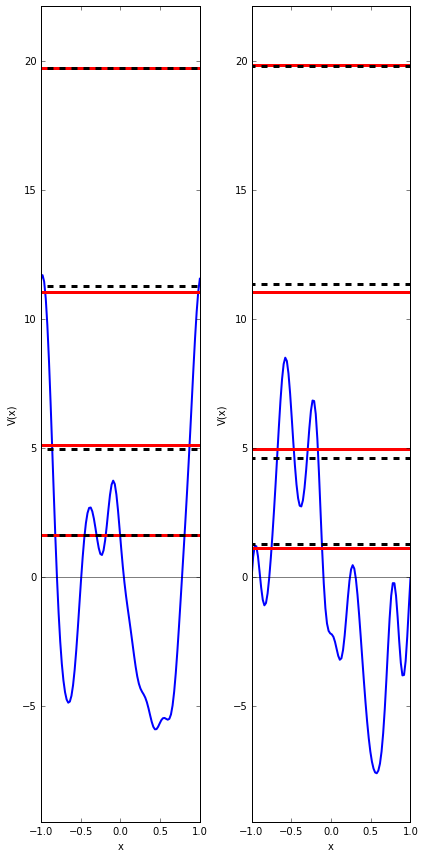

In [57]:
nrows = 1
ncols = 2
nplot = nrows * ncols
Vints = randint(0,X_test.shape[0], nplot)
Vplot = Vgrid[Vints,::]

plt.clf()
fig, axes = plt.subplots(nrows = nrows, ncols = ncols)
fig.set_size_inches(3*ncols,12*nrows)
subax = axes.flat

for i in range(0,nplot):
        subax[i].plot(xs, Vplot[i], linewidth = 2)
        subax[i].axhline(y=0,xmin=-1,xmax=1, linestyle='solid' ,color = 'k', lw=0.5)
        for j in range(0, 4):
            subax[i].axhline(y=E0(j+1)+y_pred[i,j], xmin = -1, xmax = 1, 
                             ls = 'solid', color = 'r', lw = 3)
            subax[i].axhline(y=E0(j+1)+y_test[i,j], xmin = -1, xmax = 1, 
                             ls = 'dashed', color = 'k', lw =3)

        subax[i].set_xlabel("x")
        subax[i].set_ylabel("V(x)")
        subax[i].set_ylim((-3*np.sqrt(V20),7*np.sqrt(V20)))

plt.tight_layout()
plt.show()